In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from tqdm import tqdm
import pandas as pd
import os
import pickle

# loading environment variables from .env file
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
train_dataset = pd.read_csv("../data/stormfront_train.csv")
train_dataset.head()

,text,user_id,subforum_id,num_contexts,label
0,Is it a competition on TV to get the most alie...,575589,1387,2,0
1,Here is some sound medical advice and some swe...,574902,1387,0,0
2,Screen Wait till the end when the Blond girlfr...,575736,1346,0,0
3,No it is not accepted and it is pushed in our ...,595808,1387,0,0
4,The cw are a nationalist/white pride group and...,591126,1391,0,0


In [4]:
messages_to_evaluate = pd.read_csv("../data/stormfront_test.csv")
messages_to_evaluate.head()

,text,user_id,subforum_id,num_contexts,label
0,"People.who.are.aware.of.Oildale , are.often.ab...",575505,1380,0,0
1,Part 3 - Woman by anthropology showing how dif...,584502,1348,0,0
2,"Ivan Ivanovich Shishkin , January 25 , 1832 Ma...",572043,1395,0,0
3,"Not just that , but many people who adopt kids...",579436,1393,0,0
4,I live in a suburban area with an old spring f...,737524,1359,0,0


In [5]:
# Define the pydantic class with JSON schema for hate speech detection
class HateSpeechAnalysis(BaseModel):
    '''
    A pydantic class that specifies the json schema of the hate speech detection task
    '''
    classification: str = Field(
        ..., description="Classification of the message: 'normal' or 'hate speech'"
    )
    confidence: float = Field(
        ..., ge=0, le=100, description="Confidence score of the classification (0 to 100)"
    )
    reasoning: str = Field(..., description="Brief explanation for the classification")

    class Config:
        json_schema_extra = {
            "example": {
                "classification": "normal",
                "confidence": 95,
                "reasoning": "The message contains no offensive language or discriminatory content.",
            }
        }

# Initialize the ChatOpenAI model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

In [6]:
# new prompt with Chain of Thought instructions. 

prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are an AI trained to detect hate speech. Analyze given messages and"
        " determine if they are normal or hate speech. Provide a step-by-step analysis,"
        " classification, confidence score (0-100), and brief reasoning.",
    ),
    (
        "human",
        "Here are some examples of normal messages:\n\n{normal_few_shot_examples}\n\n"
        "Here are some examples of hate speech messages:\n\n{hate_few_shot_examples}\n\n"
        "Now, analyze the following message for hate speech: {message}\n\n"
        "Please follow these steps in your analysis:\n"
        "1. Identify key words or phrases that might indicate hate speech.\n"
        "2. Consider the context and intent of the message.\n"
        "3. Evaluate if the message targets specific groups or individuals.\n"
        "4. Assess the severity of any potentially hateful content.\n"
        "5. Compare the message to the provided examples.\n"
        "6. Make a final determination (normal or hate speech).\n"
        "7. Assign a confidence score (0-100).\n"
        "8. Provide a brief reasoning for your classification."
    ),
])

# Create the chain with structured output
chain = prompt | llm.with_structured_output(HateSpeechAnalysis, include_raw=True)

# Sampling few shot examples from the training dataset

In [8]:
# total number os few shot examples
n = 100
hate_examples = (
    train_dataset[train_dataset["label"] == 1][
        ["text"]
    ]
    .sample(n // 2, random_state=42)
    .reset_index(drop=True)
)
normal_examples = (
    train_dataset[train_dataset["label"] == 0][
        ["text"]
    ]
    .sample(n // 2, random_state=42)
    .reset_index(drop=True)
)


In [9]:
# formatting the few shot examples
normal_few_shot_examples = "\n\n".join([f"{i+1}\n\tmessage: {row["text"]}\n\tlabel: normal" for i, row in normal_examples.iterrows()])
hate_few_shot_examples = "\n\n".join([f"{i+1}\n\tmessage: {row["text"]}\n\tlabel: hate speech" for i, row in hate_examples.iterrows()])

In [10]:
print(normal_few_shot_examples)

1
	message: All with an ulterior motive , of course ....
	label: normal

2
	message: I m not the only one
	label: normal

3
	message: Well, I have a few hundred bookmarked - but here 's a few that I 've looked at more than once or twice : This website has free curriculum and good advice : http://bringinguplearners.com/Iusethisoneallthetimeforplanning:http://donnayoung.org/Ifyouwishtoaddanewelementtoyourhomeschool:http://www.teachwithmovies.org/index.html Happy learning !
	label: normal

4
	message: So you advocate independence , just to join another sovereign Nation ( As Wales would be in this hypothetical scenario ) ?
	label: normal

5
	message: I seen a young Latvian girl at Prague airport with a very dark arab and their little girl about 2 was very dark .
	label: normal

6
	message: Irish, There is nothing wrong with being polite .
	label: normal

7
	message: Give them their interview but be careful not to say anything stupid.Tape the interview for legal reasons put it up on the net

In [11]:
print(hate_few_shot_examples)

1
	message: Homosexuals should stay in the closet .
	label: hate speech

2
	message: its simple , your white. your genetic code doesnt include a racial commitment to crime. be glad and for for those reasons. this is what society has turned into. take a stand and defend your race. we must secure the existence of our people and a future for white children.-david lane white racial loyalty starts here keep it white
	label: hate speech

3
	message: These areas that you name are the preserve of the rich , you wont find a single white working class person living there.We might look down on blacks and pakis as scum and not want them living near us but the upper class feel exactly the same about us
	label: hate speech

4
	message: Can someone help me find an ol ' comrade of mine who 's now rotting in a California Prison for his next two lives for allegedly victimizing anti-racist scum ?
	label: hate speech

5
	message: Why not just kick out all those Africans ?
	label: hate speech

6
	message: 

# Running the LLM chain with the whole dataset

In [12]:
# preprocessing the inputs
input_data = [
    {
        "normal_few_shot_examples": normal_few_shot_examples,
        "hate_few_shot_examples": hate_few_shot_examples,
        "message": msg,
    }
    for msg in messages_to_evaluate["text"]
]


In [14]:
classification_results = chain.batch(input_data, config={"max_concurrency": 2})


### Parsing classification results

In [15]:
classification_results[0]

{'raw': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_enqNjeUPSsDnO1gLLluDUc5t', 'function': {'arguments': '{"classification":"normal","confidence":85,"reasoning":"The message discusses a location (Oildale) and mentions intimidation and a lack of cleanliness, but does not target any specific group or promote hate. The tone appears to be light-hearted (\'lol\') and does not contain any overtly hateful language or sentiments."}', 'name': 'HateSpeechAnalysis'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 3361, 'total_tokens': 3426, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'stop', 'logprobs': None}, id='run-f33b17bb-343d-46cc-91ae-16d3c0d8ec85-0', tool_calls=[{'name': 'HateSpeechAnalysis', 'args': {'classification': 'normal', 'confidence': 85, 'reasoning': "The message discusses a locati

In [16]:
# Creating the columns
messages_to_evaluate['classification'] = ''
messages_to_evaluate["confidence"] = ""
messages_to_evaluate["reasoning"] = ""

# populating the columns
for idx in range(len(messages_to_evaluate)):
    messages_to_evaluate.loc[idx, "classification"] = classification_results[idx][
        "parsed"
    ].classification
    messages_to_evaluate.loc[idx, "confidence"] = classification_results[idx][
        "parsed"
    ].confidence
    messages_to_evaluate.loc[idx, "reasoning"] = classification_results[idx][
        "parsed"
    ].reasoning

In [17]:
messages_to_evaluate.head()

,text,user_id,subforum_id,num_contexts,label,classification,confidence,reasoning
0,"People.who.are.aware.of.Oildale , are.often.ab...",575505,1380,0,0,normal,85.0,The message discusses a location (Oildale) and...
1,Part 3 - Woman by anthropology showing how dif...,584502,1348,0,0,normal,85.0,The message discusses the beauty of women from...
2,"Ivan Ivanovich Shishkin , January 25 , 1832 Ma...",572043,1395,0,0,normal,95.0,The message is a list of artworks and their de...
3,"Not just that , but many people who adopt kids...",579436,1393,0,0,hate speech,85.0,The message implies a preference for 'pure whi...
4,I live in a suburban area with an old spring f...,737524,1359,0,0,normal,95.0,The message describes a personal living situat...


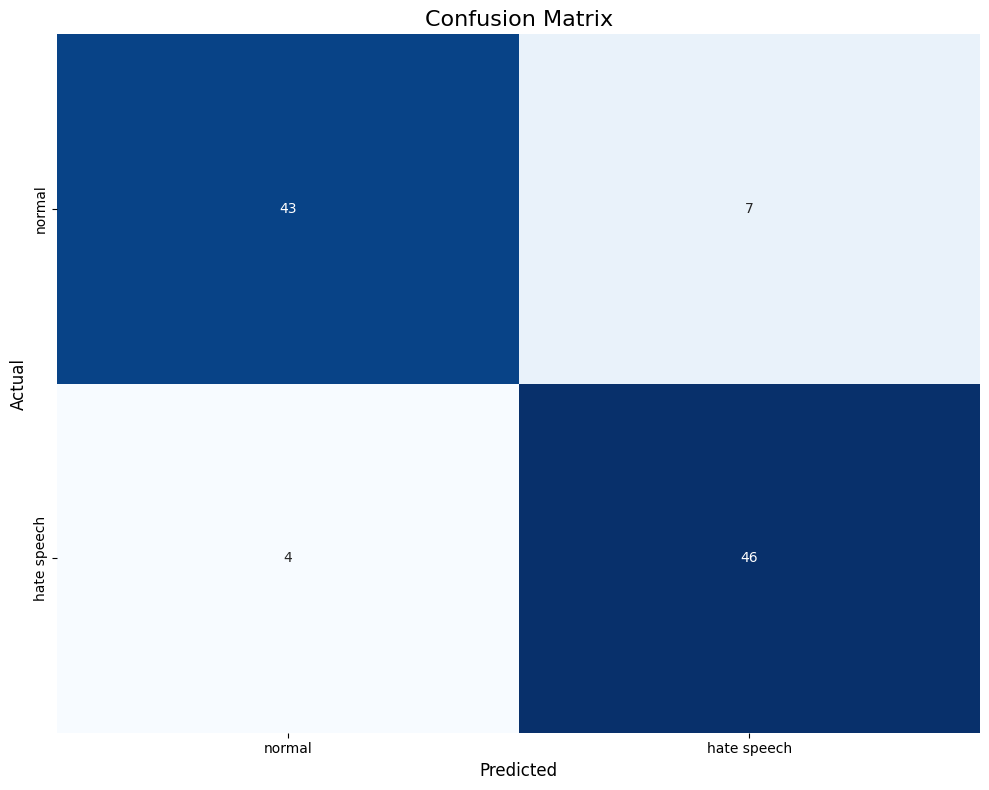

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_true = messages_to_evaluate["label"]
label_to_int = {"normal": 0, "hate speech": 1}
y_pred = messages_to_evaluate["classification"].map(label_to_int)
# Create the confusion matrix

cm = confusion_matrix(y_true, y_pred)

# Create labels for the classes 
class_names = ["normal", "hate speech"] 

# Create a figure and axis
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=False
)

# Set title and labels
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [19]:
from sklearn.metrics import classification_report, roc_auc_score, roc_auc_score
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89        50
           1       0.87      0.92      0.89        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



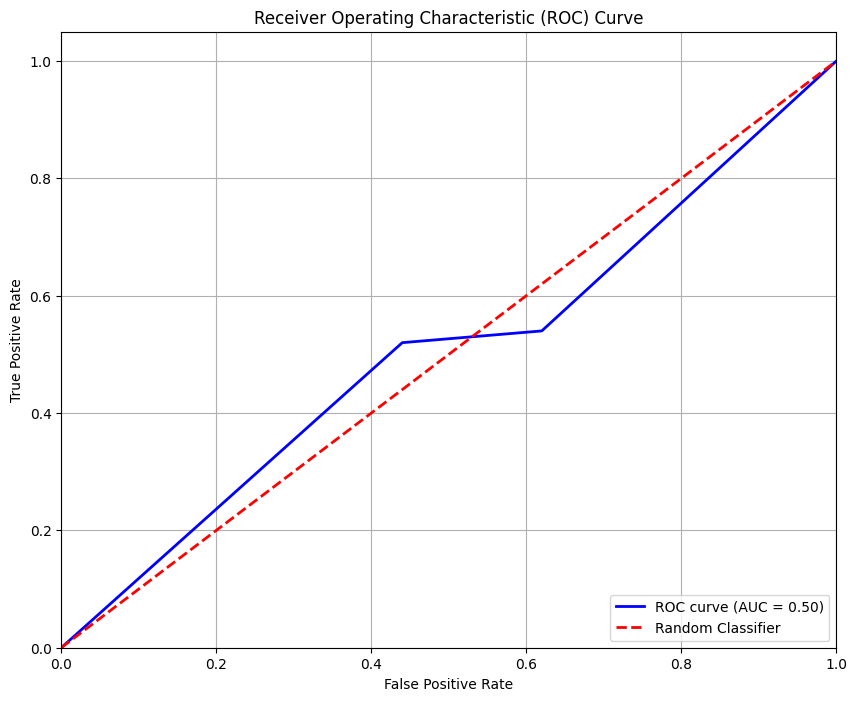

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities
y_scores = messages_to_evaluate["confidence"]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_true, y_scores)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--", label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)

# Show the plot
plt.show()
